In [235]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import json
from geopy.geocoders import Nominatim
import folium
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt 
import matplotlib.cm as cm
import matplotlib.colors as colors

##### Getting Divisions of the Turkey from Spatial Data Repository of NYU in json format

In [5]:
!wget -q -O "turkey_data.json" --no-check-certificate https://geo.nyu.edu/download/file/stanford-nj696zj1674-geojson.json
print('Data downloaded!')

Data downloaded!


In [6]:
with open("turkey_data.json",encoding='utf-8') as json_data:
    turkey_data = json.load(json_data)

In [7]:
neighborhoods_data = turkey_data['features']

In [8]:
#Create a new dataframe
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
neighborhoods_istanbul = pd.DataFrame(columns=column_names)
neighborhoods_ankara=pd.DataFrame(columns=column_names)

###### Transform the data into pandas dataframe for both Istanbul and Ankara cities

In [9]:
for data in neighborhoods_data:
    if data['properties']['name_1']=='Istanbul':
        borough = neighborhood_name = data['properties']['name_2'] 
        neighborhood_name = data['properties']['name_2']
        neighborhood_latlon = data['geometry']['coordinates'][0][0][0]
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
        neighborhoods_istanbul = neighborhoods_istanbul.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    if data['properties']['name_1']=='Ankara':
        borough = neighborhood_name = data['properties']['name_2'] 
        neighborhood_name = data['properties']['name_2']
        neighborhood_latlon = data['geometry']['coordinates'][0][0][0]
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
        neighborhoods_ankara = neighborhoods_ankara.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [10]:
neighborhoods_istanbul.head()

,Borough,Neighborhood,Latitude,Longitude
0,Çatalca,Çatalca,41.388474,28.545635
1,Çekmekoy,Çekmekoy,41.027790,29.179447
2,Adalar,Adalar,40.914860,29.051806
3,Ümraniye,Ümraniye,41.027790,29.179447
4,Üsküdar,Üsküdar,41.069862,28.208469


In [11]:
neighborhoods_istanbul.shape

(38, 4)

In [14]:
neighborhoods_ankara.head()

,Borough,Neighborhood,Latitude,Longitude
0,Çamlıdere,Çamlıdere,40.343143,32.279968
1,Çankaya,Çankaya,39.811966,32.858326
2,Çubuk,Çubuk,40.026344,32.966702
3,Akyurt,Akyurt,40.005623,33.282547
4,Altındağ,Altındağ,39.981613,33.135509


In [13]:
neighborhoods_ankara.shape

(24, 4)

###### Create a map of Istanbul with neighborhoods

In [15]:
address = 'Istanbul, TR'

geolocator = Nominatim(user_agent="ist_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Istanbul are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Istanbul are 41.0766019, 29.052495.


In [16]:
map_istanbul = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods_istanbul['Latitude'], neighborhoods_istanbul['Longitude'], neighborhoods_istanbul['Borough'], neighborhoods_istanbul['Neighborhood']):
    #label = '{}, {}'.format(neighborhood, borough)
    #label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        #popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_istanbul)  
    
map_istanbul

###### Create map of Ankara with neighborhoods

In [17]:
address = 'Ankara, TR'

geolocator = Nominatim(user_agent="ank_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Ankara are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Ankara are 39.7160439, 32.7059948.


In [18]:
map_ankara = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods_ankara['Latitude'], neighborhoods_ankara['Longitude'], 
                                           neighborhoods_ankara['Borough'], neighborhoods_ankara['Neighborhood']):
    #label = '{}, {}'.format(neighborhood, borough)
    #label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        #popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_ankara)  
    
map_ankara

###### Function for getting the venues arround boroughs with radius 1000m

In [20]:
CLIENT_ID = '0F20PR2NBH44S3ABS4E2BIMAICUQRXOYSPY4WJ3WLI3NF51Y' # your Foursquare ID
CLIENT_SECRET = 'SH4VM41WQA2ZILTU5LS2WUIYO0YVEZT3RUFUG2VL2VYIU445' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT=500

In [21]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

###### Istanbul Venues

In [119]:
istanbul_venues = getNearbyVenues(names=neighborhoods_istanbul['Neighborhood'],
                                   latitudes=neighborhoods_istanbul['Latitude'],
                                   longitudes=neighborhoods_istanbul['Longitude']
                                  )

Çatalca
Çekmekoy
Adalar
Ümraniye
Üsküdar
Arnavutkoy
Atasehir
Avcılar
Şişli
Şile
Büyükçekmece
Bağcılar
Bahçelievler
Bakırköy
Basaksehir
Bayrampaşa
Beşiktaş
Beykoz
Beylikduzu
Beyoğlu
Esenler
Esenyurt
Eyüp
Fatih
Güngören
Gaziosmanpaşa
Küçükçekmece
Kağıthane
Kadıköy
Kartal
Maltepe
Pendik
Sancaktepe
Sarıyer
Sultanbeyli
Sultangazi
Tuzla
Zeytinburnu


In [120]:
istanbul_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Çekmekoy,41.02779,29.179447,Çekmeköy Kahvesi,41.026331,29.181154,Café
1,Çekmekoy,41.02779,29.179447,Limon Fırın & Pasta,41.025881,29.181583,Bakery
2,Çekmekoy,41.02779,29.179447,ATA TERMİNAL / crossBASKETBALLfit 🏀💪🏾,41.028755,29.183664,Basketball Stadium
3,Çekmekoy,41.02779,29.179447,Tarihi Park Adana Kebapçısı,41.030539,29.174614,Turkish Restaurant
4,Çekmekoy,41.02779,29.179447,Besyildiz Kebap Pide Lahmacun,41.026707,29.180841,Steakhouse


In [128]:
istanbul_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Adalar,51,51,51,51,51,51
Arnavutkoy,29,29,29,29,29,29
Atasehir,100,100,100,100,100,100
Avcılar,100,100,100,100,100,100
Bahçelievler,100,100,100,100,100,100
Bakırköy,100,100,100,100,100,100
Basaksehir,100,100,100,100,100,100
Bayrampaşa,100,100,100,100,100,100
Bağcılar,100,100,100,100,100,100


###### Bar Plots of Istanbul Venues

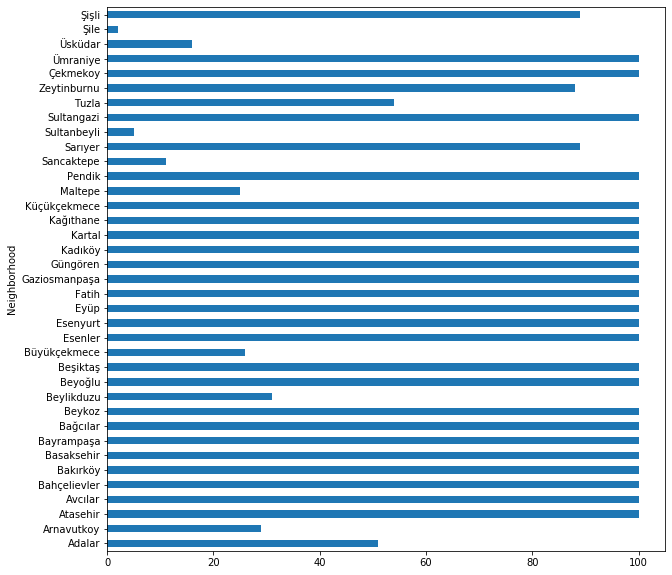

In [195]:
istanbul_venues.groupby('Neighborhood').count()['Venue'].plot.barh(legend=None,figsize=(10,10))

In [65]:
istanbul_venues.shape

(2916, 7)

###### Ankara Venues

In [67]:
ankara_venues = getNearbyVenues(names=neighborhoods_ankara['Neighborhood'],
                                   latitudes=neighborhoods_ankara['Latitude'],
                                   longitudes=neighborhoods_ankara['Longitude']
                                  )

Çamlıdere
Çankaya
Çubuk
Akyurt
Altındağ
Ayaş
Şultan Koçhisar
Bala
Beypazarı
Elmadağ
Etimesgut
Evren
Gölbaşı
Güdül
Haymana
Kızılcahamam
Kalecik
Kazan
Keçiören
Mamak
Nallıhan
Polatlı
Sincan

Yenimahalle


In [68]:
ankara_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Çankaya,39.811966,32.858326,EYMİR STAR PAİNTBALL,39.819136,32.861262,Paintball Field
1,Çankaya,39.811966,32.858326,Koçak Uluslararası Binicilik Klubü,39.819462,32.859311,Farm
2,Çankaya,39.811966,32.858326,Koçak Binicilik Klubu Teras,39.819476,32.859251,Turkish Restaurant
3,Çankaya,39.811966,32.858326,Serviste,39.812725,32.860798,Moving Target
4,Çankaya,39.811966,32.858326,Eymir Havuzbaşı Restaurant,39.812857,32.865670,Restaurant


In [160]:
ankara_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Altındağ,1,1,1,1,1,1
Elmadağ,1,1,1,1,1,1
Etimesgut,4,4,4,4,4,4
Evren,1,1,1,1,1,1
Gölbaşı,1,1,1,1,1,1
Güdül,1,1,1,1,1,1
Kazan,1,1,1,1,1,1
Keçiören,1,1,1,1,1,1
Kızılcahamam,1,1,1,1,1,1


###### Bar Plots of Ankara

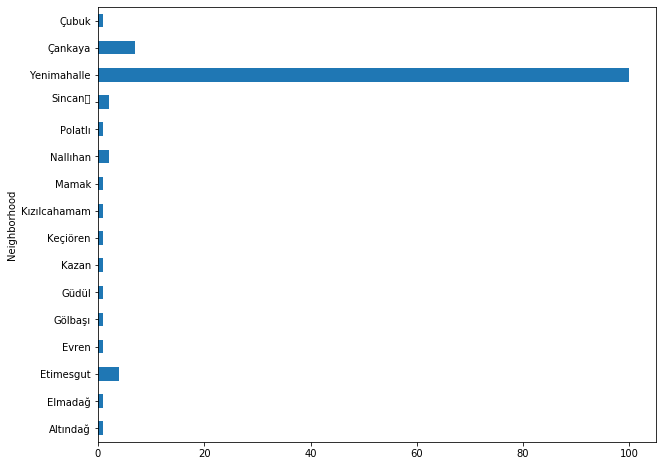

In [196]:
ankara_venues.groupby('Neighborhood').count()['Venue'].plot.barh(legend=None,figsize=(10,8))

In [164]:
ankara_venues.shape

(126, 7)

###### Analyzing Neighborhoods

In [131]:
#Onehot encoding for Ankara
ankara_onehot = pd.get_dummies(ankara_venues[['Venue Category']], prefix="", prefix_sep="")
ankara_onehot['Neighborhoods'] = ankara_venues['Neighborhood'] 
fixed_columns = [ankara_onehot.columns[-1]] + list(ankara_onehot.columns[:-1])
ankara_onehot = ankara_onehot[fixed_columns]

In [132]:
ankara_onehot.head()

,Neighborhoods,Athletics & Sports,Bagel Shop,Bakery,Botanical Garden,Breakfast Spot,Cafeteria,Café,Campground,Chinese Restaurant,...,Smoke Shop,Snack Place,Soccer Field,Sports Club,Stables,Steakhouse,Trail,Tree,Turkish Home Cooking Restaurant,Turkish Restaurant
0,Çankaya,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Çankaya,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Çankaya,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,Çankaya,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Çankaya,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [133]:
#Onehot encoding for Istanbul
istanbul_onehot = pd.get_dummies(istanbul_venues[['Venue Category']], prefix="", prefix_sep="")
istanbul_onehot['Neighborhoods'] = istanbul_venues['Neighborhood'] 
fixed_columns = [istanbul_onehot.columns[-1]] + list(istanbul_onehot.columns[:-1])
istanbul_onehot = istanbul_onehot[fixed_columns]

In [140]:
istanbul_onehot.groupby('Neighborhoods').count()

,Accessories Store,Adult Education Center,American Restaurant,Aquarium,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Athletics & Sports,Auto Dealership,...,Turkish Restaurant,Veterinarian,Watch Shop,Water Park,Waterfront,Wedding Hall,Whisky Bar,Wings Joint,Women's Store,Yoga Studio
Neighborhoods,,,,,,,,,,,,,,,,,,,,,
Adalar,51,51,51,51,51,51,51,51,51,51,...,51,51,51,51,51,51,51,51,51,51
Arnavutkoy,29,29,29,29,29,29,29,29,29,29,...,29,29,29,29,29,29,29,29,29,29
Atasehir,100,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,100
Avcılar,100,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,100
Bahçelievler,100,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,100
Bakırköy,100,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,100
Basaksehir,100,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,100
Bayrampaşa,100,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,100
Bağcılar,100,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,100


###### The mean of the frequency of occurrence of each category for Ankara

In [135]:
ankara_grouped = ankara_onehot.groupby('Neighborhoods').mean().reset_index()
ankara_grouped

,Neighborhoods,Athletics & Sports,Bagel Shop,Bakery,Botanical Garden,Breakfast Spot,Cafeteria,Café,Campground,Chinese Restaurant,...,Smoke Shop,Snack Place,Soccer Field,Sports Club,Stables,Steakhouse,Trail,Tree,Turkish Home Cooking Restaurant,Turkish Restaurant
0,Altındağ,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000
1,Elmadağ,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000
2,Etimesgut,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000
3,Evren,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000
4,Gölbaşı,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000
5,Güdül,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.0,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000
6,Kazan,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000
7,Keçiören,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000
8,Kızılcahamam,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000
9,Mamak,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000


###### 3 Most Common Venues in Neighborhoods of Ankara

In [197]:
num_top_venues = 3

for hood in ankara_grouped['Neighborhoods']:
    print("----"+hood+"----")
    temp = ankara_grouped[ankara_grouped['Neighborhoods'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Altındağ----
                venue  freq
0              Garden   1.0
1  Athletics & Sports   0.0
2           Racetrack   0.0


----Elmadağ----
                venue  freq
0            Mountain   1.0
1  Athletics & Sports   0.0
2           Racetrack   0.0


----Etimesgut----
          venue  freq
0          Farm  0.50
1      Mountain  0.25
2  Costume Shop  0.25


----Evren----
                venue  freq
0             Exhibit   1.0
1  Athletics & Sports   0.0
2        Liquor Store   0.0


----Gölbaşı----
                venue  freq
0                Farm   1.0
1  Athletics & Sports   0.0
2           Racetrack   0.0


----Güdül----
                venue  freq
0          Campground   1.0
1  Athletics & Sports   0.0
2          Restaurant   0.0


----Kazan----
                venue  freq
0           Racetrack   1.0
1  Athletics & Sports   0.0
2                Lake   0.0


----Keçiören----
                venue  freq
0                Farm   1.0
1  Athletics & Sports   0.0
2           Race

###### The mean of the frequency of occurrence of each category for Istanbul

In [136]:
istanbul_grouped = istanbul_onehot.groupby('Neighborhoods').mean().reset_index()
istanbul_grouped

,Neighborhoods,Accessories Store,Adult Education Center,American Restaurant,Aquarium,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Athletics & Sports,...,Turkish Restaurant,Veterinarian,Watch Shop,Water Park,Waterfront,Wedding Hall,Whisky Bar,Wings Joint,Women's Store,Yoga Studio
0,Adalar,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,...,0.000000,0.00,0.00,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.00
1,Arnavutkoy,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,...,0.172414,0.00,0.00,0.00,0.000000,0.00,0.00,0.068966,0.000000,0.00
2,Atasehir,0.000000,0.000000,0.01,0.000000,0.010000,0.01,0.000000,0.010000,0.000000,...,0.040000,0.00,0.00,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.00
3,Avcılar,0.000000,0.000000,0.01,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,...,0.080000,0.00,0.00,0.00,0.010000,0.00,0.00,0.010000,0.000000,0.00
4,Bahçelievler,0.000000,0.000000,0.00,0.000000,0.010000,0.00,0.000000,0.000000,0.010000,...,0.100000,0.00,0.00,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.00
5,Bakırköy,0.000000,0.000000,0.01,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,...,0.080000,0.00,0.00,0.00,0.010000,0.00,0.00,0.010000,0.000000,0.00
6,Basaksehir,0.000000,0.000000,0.00,0.010000,0.000000,0.00,0.000000,0.000000,0.000000,...,0.010000,0.00,0.00,0.00,0.000000,0.00,0.01,0.000000,0.010000,0.00
7,Bayrampaşa,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,...,0.030000,0.00,0.00,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.00
8,Bağcılar,0.000000,0.000000,0.00,0.000000,0.010000,0.01,0.000000,0.010000,0.000000,...,0.070000,0.00,0.00,0.00,0.000000,0.00,0.00,0.010000,0.000000,0.00
9,Beykoz,0.000000,0.000000,0.00,0.000000,0.000000,0.01,0.010000,0.000000,0.010000,...,0.010000,0.00,0.00,0.00,0.020000,0.00,0.00,0.000000,0.000000,0.00


###### 3 Most Common Venues in Neighborhoods of Istanbul

In [199]:
num_top_venues = 5

for hood in istanbul_grouped['Neighborhoods']:
    print("----"+hood+"----")
    temp = istanbul_grouped[istanbul_grouped['Neighborhoods'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Adalar----
                venue  freq
0                Café  0.16
1  Seafood Restaurant  0.10
2        Dessert Shop  0.08
3               Beach  0.06
4              Buffet  0.06


----Arnavutkoy----
                venue  freq
0  Turkish Restaurant  0.17
1                Farm  0.10
2            Tea Room  0.07
3         Wings Joint  0.07
4        Soccer Field  0.03


----Atasehir----
                venue  freq
0                Café  0.15
1                Park  0.06
2  Turkish Restaurant  0.04
3         Coffee Shop  0.04
4          Restaurant  0.04


----Avcılar----
                venue  freq
0                Café  0.21
1  Turkish Restaurant  0.08
2        Dessert Shop  0.06
3          Steakhouse  0.05
4          Restaurant  0.05


----Bahçelievler----
                  venue  freq
0    Turkish Restaurant  0.10
1                  Café  0.09
2  Gym / Fitness Center  0.07
3                   Gym  0.05
4                Bakery  0.04


----Bakırköy----
                venue  freq
0    

###### Sorting the venues in descending order

In [200]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [287]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhoods']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe for Ankara
neighborhoods_venues_sorted_ank = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted_ank['Neighborhoods'] = ankara_grouped['Neighborhoods']

for ind in np.arange(ankara_grouped.shape[0]):
    neighborhoods_venues_sorted_ank.iloc[ind, 1:] = return_most_common_venues(ankara_grouped.iloc[ind, :], num_top_venues)

# create a new dataframe for Istanbul
neighborhoods_venues_sorted_ist = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted_ist['Neighborhoods'] = istanbul_grouped['Neighborhoods']

for ind in np.arange(istanbul_grouped.shape[0]):
    neighborhoods_venues_sorted_ist.iloc[ind, 1:] = return_most_common_venues(istanbul_grouped.iloc[ind, :], num_top_venues)


In [269]:
neighborhoods_venues_sorted_ank

,Neighborhoods,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Altındağ,Garden,Turkish Restaurant,Donut Shop,Hookah Bar,Historic Site
1,Elmadağ,Mountain,Turkish Restaurant,Donut Shop,Historic Site,Herbs & Spices Store
2,Etimesgut,Farm,Mountain,Costume Shop,Turkish Restaurant,Donut Shop
3,Evren,Exhibit,Turkish Restaurant,Donut Shop,Hookah Bar,Historic Site
4,Gölbaşı,Farm,Turkish Restaurant,Donut Shop,Hookah Bar,Historic Site
5,Güdül,Campground,Turkish Restaurant,Donut Shop,Hookah Bar,Historic Site
6,Kazan,Racetrack,Doner Restaurant,Historic Site,Herbs & Spices Store,Gym / Fitness Center
7,Keçiören,Farm,Turkish Restaurant,Donut Shop,Hookah Bar,Historic Site
8,Kızılcahamam,Garden,Turkish Restaurant,Donut Shop,Hookah Bar,Historic Site
9,Mamak,Mountain,Turkish Restaurant,Donut Shop,Historic Site,Herbs & Spices Store


In [270]:
neighborhoods_venues_sorted_ist

,Neighborhoods,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Adalar,Café,Seafood Restaurant,Dessert Shop,Beach,Boat or Ferry
1,Arnavutkoy,Turkish Restaurant,Farm,Wings Joint,Tea Room,Plaza
2,Atasehir,Café,Park,Coffee Shop,Turkish Restaurant,Restaurant
3,Avcılar,Café,Turkish Restaurant,Dessert Shop,Steakhouse,Restaurant
4,Bahçelievler,Turkish Restaurant,Café,Gym / Fitness Center,Gym,Bakery
5,Bakırköy,Café,Turkish Restaurant,Dessert Shop,Steakhouse,Restaurant
6,Basaksehir,Coffee Shop,Hotel,Clothing Store,Sporting Goods Shop,Steakhouse
7,Bayrampaşa,Café,Coffee Shop,Clothing Store,Cosmetics Shop,Park
8,Bağcılar,Café,Turkish Restaurant,Gym / Fitness Center,Gym,Clothing Store
9,Beykoz,Café,Seafood Restaurant,Breakfast Spot,Restaurant,Historic Site


##### Clustering Neighbors

###### Applying Elbow Method for Ankara

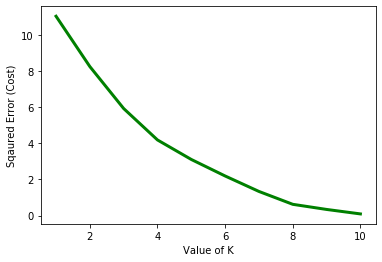

In [153]:
ankara_grouped_clustering = ankara_grouped.drop('Neighborhoods', 1)

cost =[] 
for i in range(1, 11): 
    KM = KMeans(n_clusters = i, random_state=0, max_iter = 500) 
    KM.fit(ankara_grouped_clustering) 
      
    # calculates squared error for the clustered points 
    cost.append(KM.inertia_)      

#plot the cost against K values 
plt.plot(range(1, 11), cost, color ='g', linewidth ='3') 
plt.xlabel("Value of K") 
plt.ylabel("Sqaured Error (Cost)") 
plt.show() # clear the plot 

###### Applying Elbow Method for Istanbul

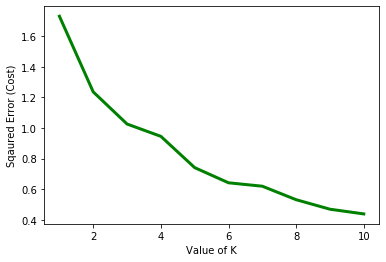

In [154]:
istanbul_grouped_clustering = istanbul_grouped.drop('Neighborhoods', 1)

cost =[] 
for i in range(1, 11): 
    KM = KMeans(n_clusters = i, random_state=0, max_iter = 500) 
    KM.fit(istanbul_grouped_clustering) 
      
    # calculates squared error for the clustered points 
    cost.append(KM.inertia_)      

#plot the cost against K values 
plt.plot(range(1, 11), cost, color ='g', linewidth ='3') 
plt.xlabel("Value of K") 
plt.ylabel("Sqaured Error (Cost)") 
plt.show() # clear the plot 

##### Optimum value k for Ankara is 8

In [155]:
kmeans_ankara = KMeans(n_clusters=8, random_state=0).fit(ankara_grouped_clustering)

###### Optimum value k for Istanbul is 6

In [157]:
kmeans_istanbul = KMeans(n_clusters=6, random_state=0).fit(istanbul_grouped_clustering)

In [288]:
# add clustering labels
neighborhoods_venues_sorted_ank.insert(0, 'Cluster Labels', kmeans_ankara.labels_)
ankara_merged = neighborhoods_ankara
ankara_merged = ankara_merged.join(neighborhoods_venues_sorted_ank.set_index('Neighborhoods'), on='Neighborhood')

In [289]:
ankara_merged = ankara_merged.fillna(-1)
ankara_merged[['Cluster Labels']]=ankara_merged[['Cluster Labels']].astype(int)

In [290]:
ankara_merged

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Çamlıdere,Çamlıdere,40.343143,32.279968,-1,-1,-1,-1,-1,-1
1,Çankaya,Çankaya,39.811966,32.858326,1,Restaurant,Turkish Restaurant,Paintball Field,Farm,Moving Target
2,Çubuk,Çubuk,40.026344,32.966702,2,Farm,Turkish Restaurant,Donut Shop,Hookah Bar,Historic Site
3,Akyurt,Akyurt,40.005623,33.282547,-1,-1,-1,-1,-1,-1
4,Altındağ,Altındağ,39.981613,33.135509,0,Garden,Turkish Restaurant,Donut Shop,Hookah Bar,Historic Site
5,Ayaş,Ayaş,40.122890,32.145702,-1,-1,-1,-1,-1,-1
6,Şultan Koçhisar,Şultan Koçhisar,38.835110,33.937115,-1,-1,-1,-1,-1,-1
7,Bala,Bala,39.330387,33.286686,-1,-1,-1,-1,-1,-1
8,Beypazarı,Beypazarı,40.122890,32.145702,-1,-1,-1,-1,-1,-1
9,Elmadağ,Elmadağ,39.813908,33.107876,4,Mountain,Turkish Restaurant,Donut Shop,Historic Site,Herbs & Spices Store


In [291]:
# add clustering labels
neighborhoods_venues_sorted_ist.insert(0, 'Cluster Labels', kmeans_istanbul.labels_)
istanbul_merged = neighborhoods_istanbul
istanbul_merged = istanbul_merged.join(neighborhoods_venues_sorted_ist.set_index('Neighborhoods'), on='Neighborhood')

In [292]:
istanbul_merged = istanbul_merged.fillna(-1)
istanbul_merged[['Cluster Labels']]=istanbul_merged[['Cluster Labels']].astype(int)

In [294]:
istanbul_merged

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Çatalca,Çatalca,41.388474,28.545635,-1,-1,-1,-1,-1,-1
1,Çekmekoy,Çekmekoy,41.027790,29.179447,1,Café,Pizza Place,Turkish Restaurant,Bakery,Restaurant
2,Adalar,Adalar,40.914860,29.051806,1,Café,Seafood Restaurant,Dessert Shop,Beach,Boat or Ferry
3,Ümraniye,Ümraniye,41.027790,29.179447,1,Café,Pizza Place,Turkish Restaurant,Bakery,Restaurant
4,Üsküdar,Üsküdar,41.069862,28.208469,0,Beach,Pool,Café,Other Great Outdoors,Basketball Court
5,Arnavutkoy,Arnavutkoy,41.132622,28.833025,4,Turkish Restaurant,Farm,Wings Joint,Tea Room,Plaza
6,Atasehir,Atasehir,41.011009,29.065571,1,Café,Park,Coffee Shop,Turkish Restaurant,Restaurant
7,Avcılar,Avcılar,40.992836,28.767378,1,Café,Turkish Restaurant,Dessert Shop,Steakhouse,Restaurant
8,Şişli,Şişli,41.108299,29.009672,4,Coffee Shop,Café,Restaurant,Pizza Place,Fast Food Restaurant
9,Şile,Şile,41.044731,29.366003,2,Bar,Lake,Yoga Studio,Flea Market,Farmers Market


###### Map of Resulting Clusters for Ankara

In [263]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)
kclusters=8
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(ankara_merged['Latitude'], ankara_merged['Longitude'], ankara_merged['Neighborhood'], ankara_merged['Cluster Labels']):
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

###### Map of Resulting Clusters for Istanbul

In [286]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)
kclusters=6
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(istanbul_merged['Latitude'], istanbul_merged['Longitude'], istanbul_merged['Neighborhood'], istanbul_merged['Cluster Labels']):
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters